## 1. Escolher uma das colunas dos dados utilizados no projeto 1 para predição (classificação ou regressão)

In [1]:
# !pip install mlflow
# !pip install --upgrade setuptools
# !pip install scikit-optimize
# !pip install xgboost

In [38]:
import pandas as pd
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import shap

import mlflow.pyfunc
import os

In [3]:
path_raw = os.getenv('PATH_RAW')
# df_raw = pd.read_csv('scraped_data.csv', sep=',')
df_raw = pd.read_csv('../scraped_data.csv', sep=',', nrows=1000)

In [4]:
df_raw.head(1)

,find_anuncio,find_condominio,find_descri,find_endereco,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,...,is_mobiliado,is_piscina,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos
0,Apartamento para venda com 105 metros quadrado...,R$ 1.100 / mês,Código do anúncio: C6BAD9\n\nO apartamento est...,"Aflitos, Recife, PE, 52050340",R$ 180,Rua da Angustura,105m²,380000,Antônio Luciano Santana da Silva,False,...,False,False,False,True,False,False,3,20,0,3


In [5]:
df_0 = df_raw.copy()

In [6]:
df_0 = df_0.drop(columns=['find_anuncio','find_descri']) 

df_0 = df_0[df_0['n_quartos'] != '5 ou mais'] # por recomendação do professor
df_0 = df_0[df_0['n_banheiros'] != '5 ou mais']
df_0 = df_0[df_0['n_garagens'] != '5 ou mais']

df_0[['Bairro','CEP']] = df_0['find_endereco'].str.split(', ', expand=True)[[0,3]]
df_0 = df_0.drop(columns=['find_endereco'])

In [7]:
# deixando como num a coluna find_condominio
df_0['find_condominio'] = df_0['find_condominio'].astype('str').str.replace('R$', '').str.replace(' / mês', '').str.replace('.', '')

# deixando como num a coluna find_iptu
df_0['find_iptu'] = df_0['find_iptu'].astype('str').str.replace('R$ ', '').str.replace('.', '')

# deixando como num a coluna find_m_quadrado
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('str').str.replace('m²', '').str.replace('.', '')

# cast direto colunas(floats devido a conseguir dar cast em NaN)
df_0['find_condominio'] = df_0['find_condominio'].astype('float')
df_0['Bairro'] = df_0['Bairro'].astype('category')
df_0['CEP'] = df_0['CEP'].astype('category')
df_0['find_iptu'] = df_0['find_iptu'].astype('float')
df_0['find_loc'] = df_0['find_loc'].astype('category')
df_0['find_m_quadrado'] = df_0['find_m_quadrado'].astype('float')
df_0['find_price'] = df_0['find_price'].astype('float')
df_0['find_vendedor'] = df_0['find_vendedor'].astype('category')
df_0['is_academia'] = df_0['is_academia'].astype('category')
df_0['is_apertamento'] = df_0['is_apertamento'].astype('category')
df_0['is_ar_condicionado'] = df_0['is_ar_condicionado'].astype('category')
df_0['is_churrasqueira'] = df_0['is_churrasqueira'].astype('category')
df_0['is_elevador'] = df_0['is_elevador'].astype('category')
df_0['is_mobiliado'] = df_0['is_mobiliado'].astype('category')
df_0['is_piscina'] = df_0['is_piscina'].astype('category')
df_0['is_portaria'] = df_0['is_portaria'].astype('category')
df_0['is_profissional'] = df_0['is_profissional'].astype('category')
df_0['is_salao_festa'] = df_0['is_salao_festa'].astype('category')
df_0['is_varanda'] = df_0['is_varanda'].astype('category')
df_0['n_banheiros'] = df_0['n_banheiros'].astype('float')
df_0['n_fotos'] = df_0['n_fotos'].astype('float')
df_0['n_garagens'] = df_0['n_garagens'].astype('float')
df_0['n_quartos'] = df_0['n_quartos'].astype('float')

In [8]:
df_0[df_0.select_dtypes(['category']).columns] = df_0.select_dtypes(['category']).apply(lambda x: x.cat.codes)

In [9]:
df_0 = df_0.drop_duplicates()

In [10]:
from fancyimpute import KNN

df_0_knn = KNN(k=2).fit_transform(df_0)

Imputing row 1/918 with 0 missing, elapsed time: 0.100
Imputing row 101/918 with 0 missing, elapsed time: 0.100
Imputing row 201/918 with 0 missing, elapsed time: 0.100
Imputing row 301/918 with 0 missing, elapsed time: 0.100
Imputing row 401/918 with 0 missing, elapsed time: 0.100
Imputing row 501/918 with 0 missing, elapsed time: 0.100
Imputing row 601/918 with 0 missing, elapsed time: 0.100
Imputing row 701/918 with 0 missing, elapsed time: 0.100
Imputing row 801/918 with 0 missing, elapsed time: 0.100
Imputing row 901/918 with 0 missing, elapsed time: 0.100


In [11]:
df_0 = pd.DataFrame(data=df_0_knn[0:,0:],columns=df_0.columns)
df_0.isna().sum()

find_condominio       0
find_iptu             0
find_loc              0
find_m_quadrado       0
find_price            0
find_vendedor         0
is_academia           0
is_apertamento        0
is_ar_condicionado    0
is_churrasqueira      0
is_elevador           0
is_mobiliado          0
is_piscina            0
is_portaria           0
is_profissional       0
is_salao_festa        0
is_varanda            0
n_banheiros           0
n_fotos               0
n_garagens            0
n_quartos             0
Bairro                0
CEP                   0
dtype: int64

In [12]:
df_0.head(1)

,find_condominio,find_iptu,find_loc,find_m_quadrado,find_price,find_vendedor,is_academia,is_apertamento,is_ar_condicionado,is_churrasqueira,...,is_portaria,is_profissional,is_salao_festa,is_varanda,n_banheiros,n_fotos,n_garagens,n_quartos,Bairro,CEP
0,1100.0,180.0,365.0,105.0,380000.0,26.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,20.0,0.0,3.0,0.0,305.0


In [13]:
df_1 = df_0.copy()

vamos escolher a coluna de preço para fazer regressão

In [14]:
y = df_1['find_price']

In [15]:
X = df_1.drop(columns=['find_price'])

## 2. Separar os dados em treinamento, validação e teste
    - Escolhemos seguir com as proporções 
        - 70:30 para treino:teste  
        - 80:20 para o treino:valid

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

## 3. Selecionar 4 algoritmos de acordo com a tarefa escolhida no passo 1

In [17]:
from sklearn.neural_network import MLPRegressor
mlpr = MLPRegressor(hidden_layer_sizes=(1024, 512, 124, 124, 64, 64, 64))

In [18]:
from sklearn.ensemble  import RandomForestRegressor
rfr = RandomForestRegressor()

In [19]:
from xgboost import XGBRegressor
xgbm = XGBRegressor()

In [20]:
from sklearn.neighbors  import KNeighborsRegressor
knnr = KNeighborsRegressor()

## 4. Adicionar MLFlow no treinamento dos modelos para rastreamento

In [21]:
import mlflow
import mlflow.sklearn

In [22]:
mlflow.set_experiment("exp_edu_0")

<Experiment: artifact_location='file:///C:/Users/Thamires/Desktop/Edu%20repos/scraping/notebook_analysis/mlruns/365906893027345415', creation_time=1720434795232, experiment_id='365906893027345415', last_update_time=1720434795232, lifecycle_stage='active', name='exp_edu_0', tags={}>

## 5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação

In [23]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [24]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Selecionar poucos hiper-parâmetros por algoritmo (max. 3)

#### MLP

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

search_space = {
    'learning_rate':["constant", "invscaling", "adaptive"],
    'learning_rate_init':[0.01, 0.001, 0.0001]
}

opt = BayesSearchCV(
    estimator=mlpr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val_scaled, y_val)

best_model_mlpr = MLPRegressor(**opt.best_params_)
print("Best parameters found: ", opt.best_params_)

C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['invscaling', 0.001] before, using random point ['invscaling', 0.0001]
  warnings.warn(
C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['invscaling', 0.001] before, using random point ['invscaling', 0.001]
  warnings.warn(
C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['constant', 0.001] before, using random point ['adaptive', 0.01]
  warnings.warn(


Best parameters found:  OrderedDict([('learning_rate', 'invscaling'), ('learning_rate_init', 0.001)])


C:\Users\Thamires\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\Thamires\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Thamires\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


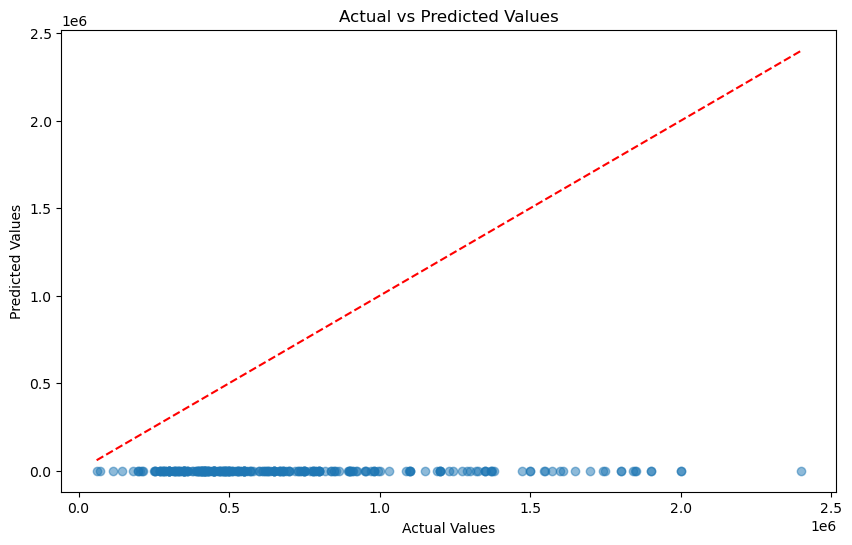

Root Mean Squared Error: 810587.8978344327


In [27]:
# Start an MLflow run
with mlflow.start_run(run_name="MLPRegressor"):
    # Log parameters
    mlflow.log_params(opt.best_params_)

    best_model_mlpr.fit(X_train_scaled,y_train)

    y_pred = best_model_mlpr.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_mlpr, 'model')


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')

In [28]:
y_pred_test = best_model_mlpr.predict(X_test_scaled)
y_pred_train = best_model_mlpr.predict(X_train_scaled)
# Calculate MSE for training set
train_mse = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Calculate MSE for test set
test_mse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {train_mse}")
print(f"Test  RMSE: {test_mse}")

Train RMSE: 786381.6822616851
Test  RMSE: 810587.8978344327


#### Random forest

C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['squared_error', 'sqrt'] before, using random point ['absolute_error', 'sqrt']
  warnings.warn(
C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['squared_error', 'sqrt'] before, using random point ['squared_error', 'sqrt']
  warnings.warn(
C:\Users\Thamires\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point ['squared_error', 'sqrt'] before, using random point ['squared_error', 'sqrt']
  warnings.warn(


Best parameters found:  OrderedDict([('criterion', 'squared_error'), ('max_features', 'sqrt')])


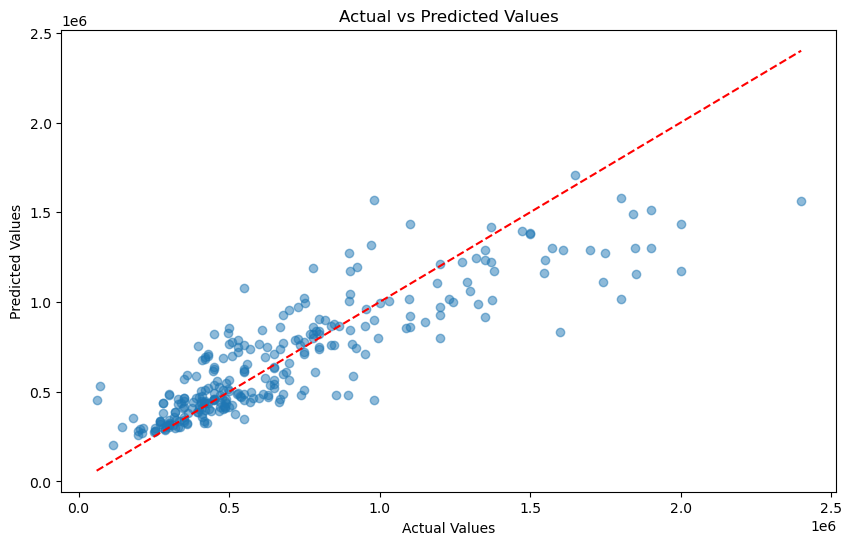

Root Mean Squared Error: 213662.93357796106


In [29]:
search_space = {
    'criterion': ("squared_error", "absolute_error", "friedman_mse", "poisson"), 
    'max_features':("sqrt", "log2") 
}

opt = BayesSearchCV(
    estimator=rfr,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)


best_model_rfr = RandomForestRegressor(**opt.best_params_)
print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="RandomForestRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_rfr.fit(X_train,y_train)
    y_pred = best_model_rfr.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_rfr, 'model')

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')

#### XGboost

Best parameters found:  OrderedDict([('learning_rate', 0.15849201309311142), ('max_depth', 4), ('n_estimators', 319)])


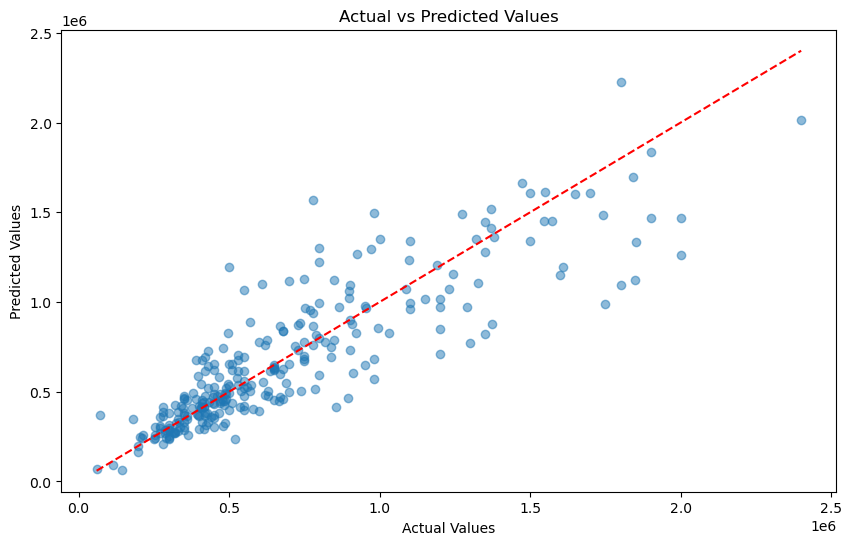

Root Mean Squared Error: 209602.6207191535


In [30]:
search_space = {
    'learning_rate': (0.01, 0.3, 'log-uniform'), 
    'max_depth': (3, 10), 
    'n_estimators': (50, 500)
}

opt = BayesSearchCV(
    estimator=xgbm,
    search_spaces=search_space,
    n_iter=15,  
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)

best_model_xgbm = XGBRegressor(**opt.best_params_, random_state=42)

print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="XGBRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_xgbm.fit(X_train,y_train)

    y_pred = best_model_xgbm.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)

    mlflow.sklearn.log_model(best_model_xgbm, 'model')


    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')


#### knn

Best parameters found:  OrderedDict([('metric', 'manhattan'), ('n_neighbors', 11), ('weights', 'distance')])


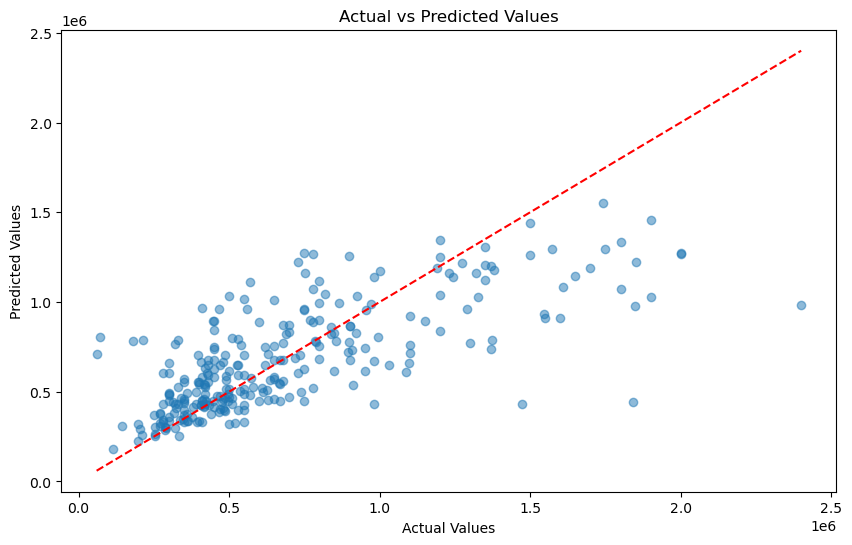

Root Mean Squared Error: 293292.75393638737


In [31]:
search_space = {
    'n_neighbors': (1, 50),
    'weights': ('uniform', 'distance'),
    'metric': ('euclidean', 'manhattan', 'minkowski')
}

opt = BayesSearchCV(
    estimator=knnr,
    search_spaces=search_space,
    n_iter=15,
    cv=kfold,
    scoring=mse_scorer,
    n_jobs=-1,
    random_state=42
)

opt.fit(X_val, y_val)

best_model_knnr = KNeighborsRegressor(**opt.best_params_)

print("Best parameters found: ", opt.best_params_)

with mlflow.start_run(run_name="KNeighborsRegressor"):
    mlflow.log_params(opt.best_params_)

    best_model_knnr.fit(X_train, y_train)
    y_pred = best_model_knnr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mlflow.log_metric('RMSE', rmse)
    mlflow.sklearn.log_model(best_model_knnr, 'model')

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')

    plot_file = "sample_plot.png"
    plt.savefig(plot_file)
    mlflow.log_artifact(plot_file, artifact_path="plots")

    plt.show()

    print(f'Root Mean Squared Error: {rmse}')


### Selecionar o modelo (algoritmo+valores de hiper-parâmetros) com melhor resultado na métrica de avaliação
    - o Xgboost foi o que teve menor RMSE (209602.6207191535) 
    

In [32]:
model_path = os.path.expanduser("mlruns/365906893027345415/01ac12ca826d4070a6e258ae80b792e0/artifacts/model")

# Carregue o modelo
model = mlflow.pyfunc.load_model(model_path)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test, model.predict(X_test)))}')

RMSE: 209602.6207191535


Executar o melhor modelo de cada algoritmo no conjunto de teste e
selecionar o melhor modelo geral na métrica de avaliação

TODO: comentar sobre cada um 

In [33]:
best_model_mlpr.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [34]:
best_model_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
best_model_xgbm.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.15849201309311142,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 319,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [36]:
best_model_knnr.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'distance'}

## 6. Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico

In [39]:
shap.initjs()

In [43]:
masker = shap.maskers.Independent(X_test)
explainer = shap.Explainer(best_model_xgbm.predict, masker)
shap_values = explainer(X_test)

Permutation explainer: 277it [00:27,  6.95it/s]                         


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


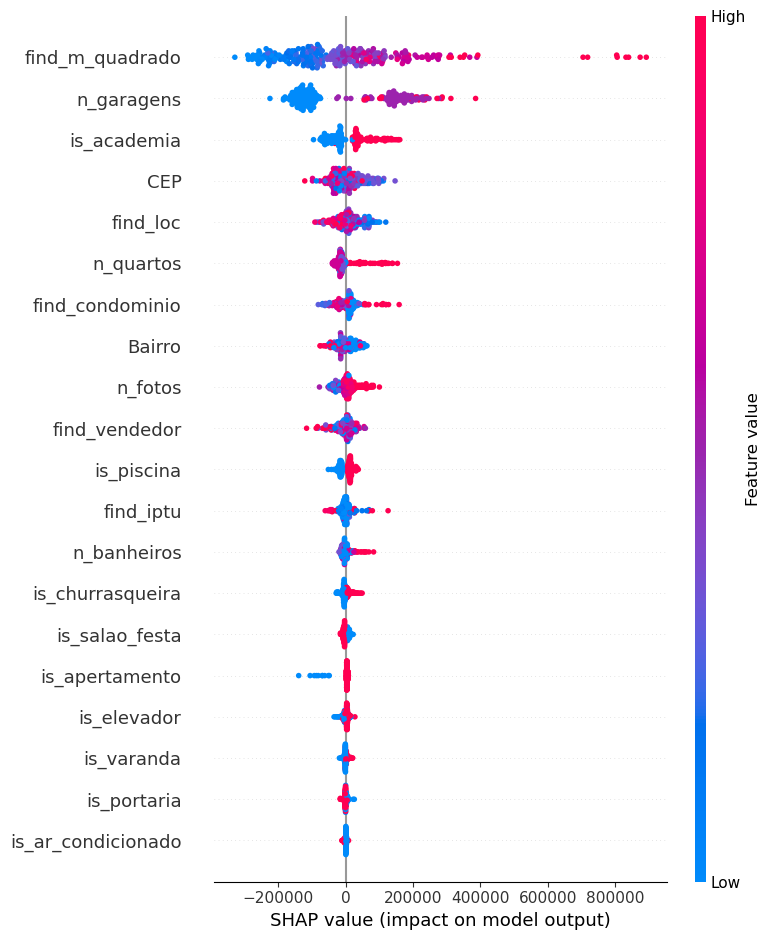

In [44]:
shap.summary_plot(shap_values.values, X_test, plot_type="dot")

vamos olhar para o top3 variáveis com maior importância

In [45]:
top_3_vars = ['find_m_quadrado', 'n_garagens', 'is_academia']

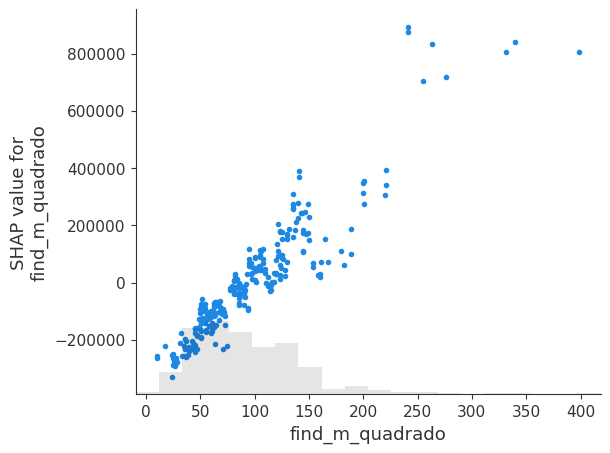

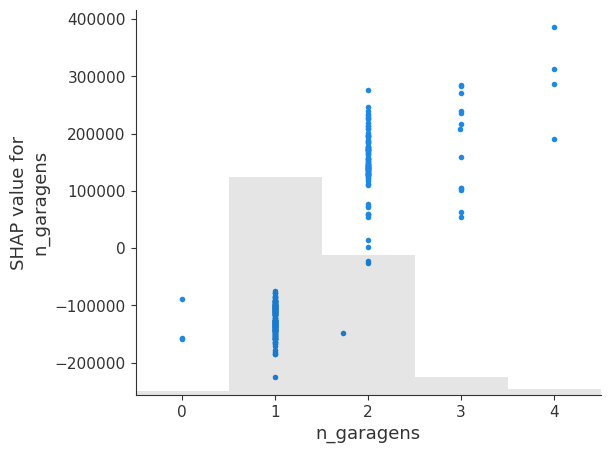

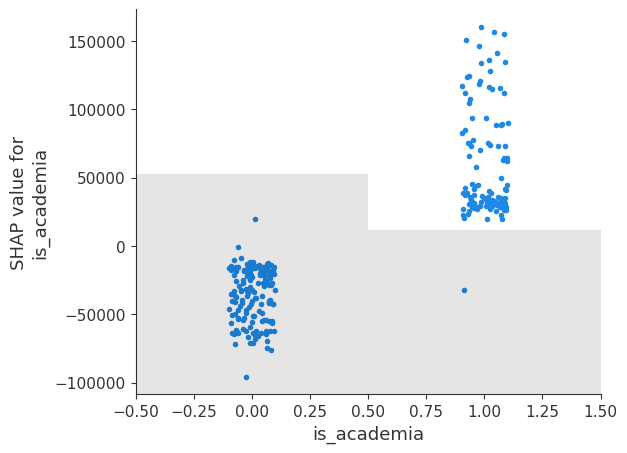

In [51]:
for var in top_3_vars:
    shap.plots.scatter(shap_values[:, var])

In [58]:
X_test['find_price'] = y_test  

quintile_analysis = {}
for var in top_3_vars:
    if X_test[var].nunique() > 10:
        X_test['quintile'] = pd.qcut(X_test[var], 5, labels=False, duplicates='drop')
        quintile_means = X_test.groupby('quintile')['find_price'].mean().reset_index()
        quintile_means.columns = ['quintile', 'mean_find_price']
    else:
        quintile_means = X_test.groupby(var)['find_price'].mean().reset_index()
        quintile_means.columns = [var, 'mean_find_price']
    quintile_analysis[var] = quintile_means
    if 'quintile' in X_test.columns:
        X_test.drop(columns='quintile', inplace=True)

for var in top_3_vars:
    print(f"Análise Bivariada para a variável: {var}")
    print(quintile_analysis[var])
    print("\n")

Análise Bivariada para a variável: find_m_quadrado
   quintile  mean_find_price
0         0     3.329466e+05
1         1     4.901202e+05
2         2     6.453883e+05
3         3     8.225601e+05
4         4     1.197692e+06


Análise Bivariada para a variável: n_garagens
   n_garagens  mean_find_price
0    0.000000     1.600000e+05
1    1.000000     3.990000e+05
2    1.000000     4.532526e+05
3    1.727866     4.500000e+05
4    2.000000     9.370242e+05
5    2.989028     1.290000e+06
6    3.000000     1.517075e+06
7    4.000000     1.650000e+06


Análise Bivariada para a variável: is_academia
   is_academia  mean_find_price
0          0.0    646668.753165
1          1.0    748049.059322




Olhando para a análise bivariada, conseguimos ver uma tendência geral que:

    - Quanto maior o m², maior a média do preço do imóvel.
    - Quanto maior a quantidade de garagens, maior a média do preço do imóvel.
    - Quando tem academia, maior a média do preço do imóvel.

E quando olhamos para o SHAP (análise olhando tanto para o gráfico de beeswarm quanto para o dependence plot):

    - Quanto maior o m², maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    - Quanto maior a quantidade de garagens, maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    - Quando tem academia, maior os valores SHAP (maior os valores de saída do modelo, ou seja, maior o preço do imóvel que o modelo dá como saída).
    
Vimos que tanto na análise bivariada com o alvo quanto olhando para os valores SHAP, concordamos na sua tendência, ponto positivo mostrando que o modelo está reproduzindo o comportamento esperado dessas variáveis para a base de teste.